In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# For modeling
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
sns.set_theme(style='whitegrid')
pd.options.mode.chained_assignment = None  # Supress warning, default='warn'

# Read Data

In [2]:
df = pd.read_csv('../data/preprocessed/accepted_2007_to_2018Q4_preprocessed.csv')
print(f"Shape of df: {df.shape}")
df.head(5)

Shape of df: (1345310, 101)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,3600.0,3600.0,3600.0,36,13.99,123.03,C,C4,10.0,MORTGAGE,...,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,N,Cash,N
1,24700.0,24700.0,24700.0,36,11.99,820.28,C,C1,10.0,MORTGAGE,...,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,N,Cash,N
2,20000.0,20000.0,20000.0,60,10.78,432.66,B,B4,10.0,MORTGAGE,...,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,N,Cash,N
3,10400.0,10400.0,10400.0,60,22.45,289.91,F,F1,3.0,MORTGAGE,...,60.0,0.0,0.0,439570.0,95768.0,20300.0,88097.0,N,Cash,N
4,11950.0,11950.0,11950.0,36,13.44,405.18,C,C3,4.0,RENT,...,100.0,0.0,0.0,16900.0,12798.0,9400.0,4000.0,N,Cash,N


In [3]:
df.dtypes

loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                            int64
int_rate                      float64
                               ...   
total_bc_limit                float64
total_il_high_credit_limit    float64
hardship_flag                  object
disbursement_method            object
debt_settlement_flag           object
Length: 101, dtype: object

## Take Sample to Work with
TODO: Delete this later and run notebook on full data

In [4]:
# Take only fraction of the data
df = df.sample(frac = 0.33)
print(df.shape)

(443952, 101)


# Encode Categorical / Nominal Columns to numeric with OHE

In [5]:
# Preview categorical data
df.dtypes[df.dtypes == "object"]

grade                   object
sub_grade               object
home_ownership          object
verification_status     object
pymnt_plan              object
purpose                 object
addr_state              object
initial_list_status     object
application_type        object
hardship_flag           object
disbursement_method     object
debt_settlement_flag    object
dtype: object

In [6]:
# Drop categorical columns that have too many realization for OHE
df = df.drop(["sub_grade", "purpose", "grade", "addr_state"], axis=1)
df.dtypes[df.dtypes == "object"]

home_ownership          object
verification_status     object
pymnt_plan              object
initial_list_status     object
application_type        object
hardship_flag           object
disbursement_method     object
debt_settlement_flag    object
dtype: object

## One Hot Encoder (OHE) of categorical data

In [7]:
# Get categorical columns names
categorical_columns = list(df.dtypes[df.dtypes == "object"].keys())
# Transform those categorical columns using One Hot Encoding
df = pd.get_dummies(data=df, columns=categorical_columns, drop_first=True)
# Preview
df.head(10)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,...,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,disbursement_method_DirectPay,debt_settlement_flag_Y
241182,4500.0,4500.0,4500.0,36,6.24,137.39,2.0,40000.0,0,12.60,...,0,0,0,1,1,0,1,0,0,0
326363,13925.0,13925.0,13925.0,60,10.99,302.70,0.0,75000.0,0,19.07,...,0,0,0,1,0,0,1,0,0,0
818812,15000.0,15000.0,15000.0,36,12.49,501.74,7.0,43000.0,0,17.30,...,0,0,0,0,0,0,0,0,0,0
1073559,10625.0,10625.0,10625.0,36,15.88,372.92,7.0,75000.0,0,18.98,...,0,0,0,0,0,0,1,0,0,0
160434,27000.0,27000.0,27000.0,60,13.33,618.91,10.0,65000.0,0,21.95,...,0,0,0,1,0,0,1,0,0,0
1009524,25000.0,25000.0,24950.0,36,7.90,782.26,2.0,80000.0,0,8.20,...,0,0,0,1,0,1,0,0,0,0
630393,27200.0,27200.0,27200.0,36,6.97,839.49,5.0,160000.0,0,5.94,...,0,0,0,1,0,0,1,0,0,0
1068505,20000.0,20000.0,20000.0,36,13.05,674.37,0.0,60000.0,0,21.70,...,0,0,0,0,0,1,0,0,0,0
529302,6000.0,6000.0,6000.0,36,7.21,185.84,NaN,42000.0,0,22.51,...,0,0,0,0,0,0,1,0,0,0
246407,10000.0,10000.0,10000.0,36,7.26,309.97,3.0,75000.0,0,15.88,...,0,0,0,1,1,0,0,0,0,0


In [8]:
# Show types of columns and counter
df.dtypes.value_counts()

float64    87
uint8      11
int64       2
dtype: int64

In [9]:
# Convert all values to float
df = df.astype(float)
# Preview
df.dtypes.value_counts()

float64    100
dtype: int64

# Preprocessing

In [10]:
# Fill NaNs with Median
df = df.fillna(df.median())
# Preview
df.head(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,loan_status,dti,...,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,initial_list_status_w,application_type_Joint App,disbursement_method_DirectPay,debt_settlement_flag_Y
241182,4500.0,4500.0,4500.0,36.0,6.24,137.39,2.0,40000.0,0.0,12.60,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
326363,13925.0,13925.0,13925.0,60.0,10.99,302.70,0.0,75000.0,0.0,19.07,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
818812,15000.0,15000.0,15000.0,36.0,12.49,501.74,7.0,43000.0,0.0,17.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1073559,10625.0,10625.0,10625.0,36.0,15.88,372.92,7.0,75000.0,0.0,18.98,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
160434,27000.0,27000.0,27000.0,60.0,13.33,618.91,10.0,65000.0,0.0,21.95,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Data Split

In [11]:
# Fraction of test data
TEST_SIZE = 0.3

X = df.drop("loan_status", axis=1)
y = df["loan_status"]

# Split data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=1997, stratify=y)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (310766, 99)
Shape of X_test: (133186, 99)
Shape of y_train: (310766,)
Shape of y_test: (133186,)


## Scale Data

In [12]:
# Init object
scaler = StandardScaler()
# Scale X_train
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,-0.275994,-0.275202,-0.272636,1.776471,0.685929,-0.545980,0.007126,-0.016835,1.194689,-0.361914,...,-0.006468,-0.009988,-0.347659,-0.810176,-0.794760,1.489767,0.846790,-0.138789,-0.070961,-0.160084
1,-0.370666,-0.369914,-0.367324,-0.562914,1.671941,-0.059356,-1.669521,-0.627602,-0.458147,0.774014,...,-0.006468,-0.009988,-0.347659,1.234300,-0.794760,1.489767,-1.180931,-0.138789,-0.070961,-0.160084
2,0.183022,0.184006,0.183591,1.776471,0.160337,-0.250215,0.007126,0.708385,-0.996733,-0.361914,...,-0.006468,-0.009988,-0.347659,-0.810176,1.258242,-0.671246,-1.180931,-0.138789,-0.070961,-0.160084
3,-0.275994,-0.275202,-0.272636,-0.562914,0.774229,-0.039294,1.124891,0.316766,-0.003918,1.909941,...,-0.006468,-0.009988,-0.347659,-0.810176,-0.794760,-0.671246,0.846790,-0.138789,-0.070961,-0.160084
4,-0.505502,-0.504806,-0.502184,-0.562914,0.500921,-0.336590,1.124891,-0.379446,1.337446,-0.361914,...,-0.006468,-0.009988,-0.347659,1.234300,-0.794760,1.489767,0.846790,-0.138789,-0.070961,-0.160084


# Fit Model

In [13]:
%%time
lr = LogisticRegression(fit_intercept=True, max_iter=700, solver="saga")
lr.fit(X_train_scaled, y_train)

# Print coefficients and intercept
print(f"Intercept: {lr.intercept_}")
print(f"Coefficients: {lr.coef_}")

Intercept: [-2.95539919]
Coefficients: [[ 2.51282464e+00  2.55649916e+00  2.53033999e+00  5.78666368e-01
  -8.07588482e-02  2.40214007e+00  1.40353735e-02 -1.43768360e-02
   6.93716085e-02 -2.55294150e-02  3.31342138e-02  3.33067864e-02
  -2.82857540e-03  2.12775978e-02 -1.56400125e-02  5.12961946e-03
   1.33118988e-02 -6.56490120e-02  5.76919409e-02  0.00000000e+00
   0.00000000e+00 -3.66970890e+00 -3.64093152e+00 -5.13399194e+00
   1.72956835e+00  1.24758647e-01  3.09096157e+00  2.68430311e+00
  -3.18387599e+00 -1.54725184e+00 -1.37215450e-02 -9.60064717e-03
   4.58443278e-03  0.00000000e+00 -1.02574656e-02 -4.59207612e-03
  -7.95531489e-02 -2.17962922e-02  3.63879098e-02 -1.10669517e-01
   8.70835377e-02  5.90684058e-02 -4.84520506e-02  4.07794426e-03
  -1.42961645e-02 -2.05037596e-03 -5.31577066e-02  2.39037287e-02
   3.64287588e-02 -1.60700835e-02  1.88929387e-02  2.21272614e-02
  -6.03971752e-02  1.79227787e-02  4.02374965e-02  2.94976352e-02
  -7.07540403e-04 -2.76471270e-04  3.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Test Model

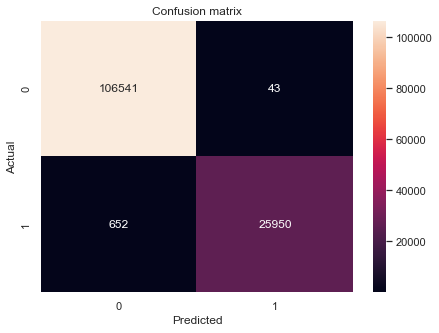

________________________________________________________________________________
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    106584
         1.0       1.00      0.98      0.99     26602

    accuracy                           0.99    133186
   macro avg       1.00      0.99      0.99    133186
weighted avg       0.99      0.99      0.99    133186

Information:
Precision: Percentage of correct positive predictions relative to total positive predictions
Recall: Percentage of correct positive predictions relative to total actual positives.
F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.
________________________________________________________________________________


In [14]:
# Scale Test Samples
X_test_scaled = scaler.transform(X_test)

# Predict in-sample values
y_pred = lr.predict(X_test_scaled)

# Plot Confusion matrics
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

# Heatmap plot settings
plt.figure(figsize=(7,5))
plt.title("Confusion matrix")
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot classification report
print(80 * "_")
print(classification_report(y_true=y_test, y_pred=y_pred))
print("Information:")
print("Precision: Percentage of correct positive predictions relative to total positive predictions")
print("Recall: Percentage of correct positive predictions relative to total actual positives.")
print("F1 Score: A weighted harmonic mean of precision and recall. The closer to 1, the better the model.")
print(80 * "_")

In [51]:
# Get Probability Predictions
pred_proba = pd.DataFrame(lr.predict_proba(X_test_scaled), columns=["P(y=0|x)", "P(y=1|x)"])
# Round to 5 decimal places
pred_proba = pred_proba.round(5)

pred_proba["y_pred"] = y_pred
pred_proba["y_actual"] = y_test.values

pred_proba.head(30)

,P(y=0|x),P(y=1|x),y_pred,y_actual
0,1.00000,0.00000,0.0,0.0
1,0.99746,0.00254,0.0,0.0
2,0.00001,0.99999,1.0,1.0
3,0.99320,0.00680,0.0,0.0
4,0.00060,0.99940,1.0,1.0
5,1.00000,0.00000,0.0,0.0
6,0.98618,0.01382,0.0,0.0
7,0.99994,0.00006,0.0,0.0
8,0.99788,0.00212,0.0,0.0
9,0.00000,1.00000,1.0,1.0
